# Calculate Mean and Standard Deviation

In [29]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

# Data directory
data_dir = 'data/ycbv_classification/'

# Define dataset
dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transform)
                  for x in ['train', 'val']}

# Define dataloader to calculate the mean and std
train_loader = DataLoader(dataset=dataset['train'], batch_size=1024, shuffle=False)

def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squares_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squares_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squares_sum/num_batches - mean**2)**0.5

    return mean, std

mean, std = get_mean_std(train_loader)

# Convert mean and std tensors to lists for Normalize
mean = mean.tolist()
std = std.tolist()

print(f"Mean: {mean}")
print(f"Mean: {std}")

Mean: [0.54571533203125, 0.5091448426246643, 0.4674311876296997]
Mean: [0.2744302451610565, 0.2780146896839142, 0.3035961091518402]


# Load Data

In [30]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/ycbv_classification/'

dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(
    dataset[x], 
    batch_size=4, 
    shuffle=True, 
    num_workers=4)
               for x in ['train', 'val']}


dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}
class_names = dataset['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize first few images

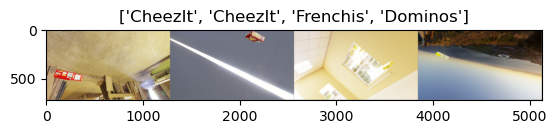

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
 
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from Tensor to NumPy
    
    mean = np.array([0.54571533203125, 0.5091448426246643, 0.4674311876296997])
    std = np.array([0.2744302451610565, 0.2780146896839142, 0.3035961091518402])
    
    inp = std * inp + mean  # Reverse normalization
    inp = np.clip(inp, 0, 1)  # Ensure valid range
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to allow update

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:10], nrow=10)

# Display images with the computed MEAN and std
imshow(out, title=[class_names[x] for x in classes[:10]])

# Define training function

In [32]:
import torch
from tempfile import TemporaryDirectory
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os

torch.cuda.empty_cache() # clear unused gpu memory
cudnn.benchmark = True # Enables inbuilt auto-tuner to find best algorithm for your hardware

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    # Tracking best models weights 
    # Only the best model is kept
    with TemporaryDirectory() as tempdir:
        
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        
        best_acc = 0.0

        for epoch in range(num_epochs):
            
            # Print out epochs - see later on
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and valing/validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Visualize images with predicted values

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetune

In [39]:
import torch
import torchvision
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
num_classes = len(class_names)
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train model

In [40]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.6139 Acc: 0.3333
val Loss: 1.7266 Acc: 0.3333

Epoch 1/14
----------
train Loss: 1.4267 Acc: 0.3485
val Loss: 1.2153 Acc: 0.4583

Epoch 2/14
----------
train Loss: 1.5090 Acc: 0.4697
val Loss: 0.5062 Acc: 0.7500

Epoch 3/14
----------
train Loss: 0.9265 Acc: 0.6061
val Loss: 0.3824 Acc: 0.8333

Epoch 4/14
----------
train Loss: 0.6708 Acc: 0.7121
val Loss: 0.4722 Acc: 0.7083

Epoch 5/14
----------
train Loss: 0.5683 Acc: 0.7576
val Loss: 0.7380 Acc: 0.7083

Epoch 6/14
----------
train Loss: 0.3707 Acc: 0.8485
val Loss: 0.8053 Acc: 0.7083

Epoch 7/14
----------
train Loss: 0.3078 Acc: 0.8788
val Loss: 0.2797 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.3071 Acc: 0.9091
val Loss: 0.1487 Acc: 1.0000

Epoch 9/14
----------
train Loss: 0.1995 Acc: 0.9394
val Loss: 0.1664 Acc: 0.9583

Epoch 10/14
----------
train Loss: 0.1371 Acc: 0.9848
val Loss: 0.1709 Acc: 0.9583

Epoch 11/14
----------
train Loss: 0.1799 Acc: 0.9545
val Loss: 0.1714 Acc: 0.9583

Ep

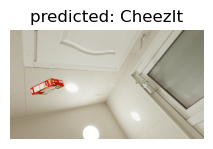

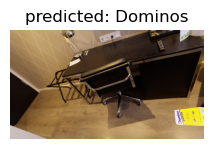

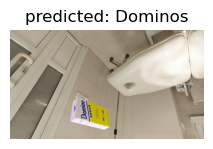

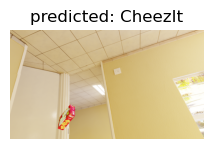

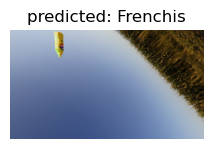

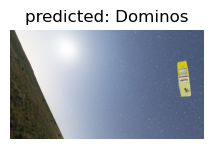

In [41]:
visualize_model(model)

In [42]:
def visualize_multiple_predictions(model, data_loader, num_images=4):
    model.eval()
    images_shown = {cls: 0 for cls in class_names}
    
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(num_images * 3, len(class_names) * 3))
    axes = axes if len(class_names) > 1 else [axes]  # Ensure axes is iterable

    def denormalize(img_tensor):
        # Denormalize using mean and std from the dataset transformation
        mean = torch.tensor([0.485, 0.456, 0.406])  # Replace with your dataset mean
        std = torch.tensor([0.229, 0.224, 0.225])    # Replace with your dataset std
        img_tensor = img_tensor * std[:, None, None] + mean[:, None, None]
        return img_tensor.clamp(0, 1)  # Clip values to [0, 1]

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                actual_class = class_names[labels[i]]
                predicted_class = class_names[preds[i]]

                if images_shown[actual_class] < num_images:
                    row = class_names.index(actual_class)
                    col = images_shown[actual_class]
                    
                    ax = axes[row][col] if len(class_names) > 1 else axes[col]
                    ax.axis("off")
                    ax.set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")

                    # Denormalize and transpose the image tensor for display
                    img = denormalize(inputs[i].cpu()).numpy().transpose((1, 2, 0))
                    ax.imshow(img)
                    
                    images_shown[actual_class] += 1

                if all(count >= num_images for count in images_shown.values()):
                    plt.tight_layout()
                    plt.show()
                    return  # Stop once all images are collected

    plt.tight_layout()
    plt.show()

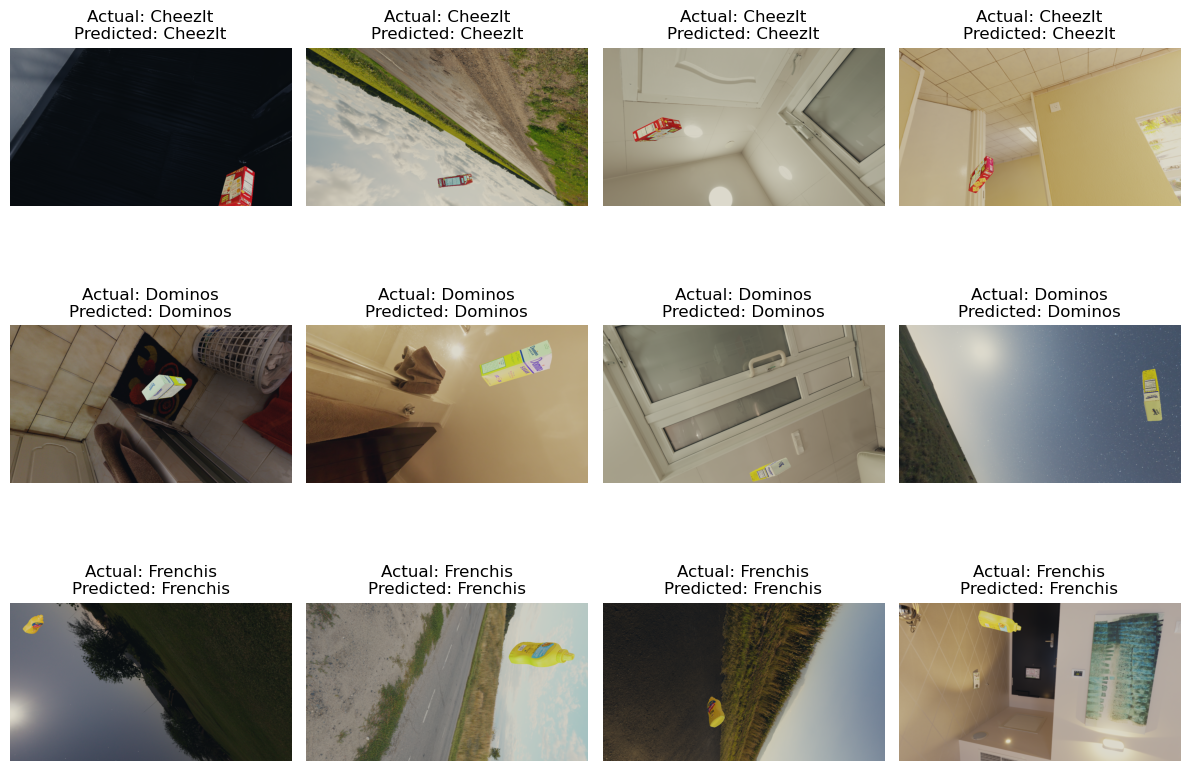

In [43]:
visualize_multiple_predictions(model, dataloaders['val'])

plt.ioff()
plt.show()